
# Detección del Estado de Ánimo en Gatos mediante Imágenes (Gatección)

El problema a resolver en este proyecto es la detección automática del estado de ánimo en gatos a partir de imágenes. Los gatos suelen tener señales emocionales sutiles, expresadas a través de pequeñas variaciones en su rostro y postura corporal. 

Para entrenar el modelo se utilizarán dos conjuntos de datos: el Cat Faces Dataset, disponible en https://www.kaggle.com/datasets/crawford/cat-dataset, el Animal Faces HQ AFHQ, accesible https://www.kaggle.com/datasets/andrewmvd/animal-faces y el The Oxford-IIIT Pet Dataset, disponible en https://www.robots.ox.ac.uk/~vgg/data/pets/ . Las fuentes contienen miles de imágenes de gatos con variabilidad en ángulos, expresiones y poses. Aunque no incluyen etiquetas emocionales explícitas, se aplicará un proceso de etiquetado manual, basado en criterios etológicos como posición de orejas, ojos, bigotes y tensión corporal.

La solución propuesta consiste en entrenar una red neuronal convolucional (CNN), compuesta por capas convolucionales, de agrupamiento pooling y densas, finalizando en una capa softmax que clasifique los estados emocionales (relajado, alerta, estresado, molesto). 

In [117]:
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torch
from sklearn.metrics import precision_score
from collections import Counter
import random, torch, matplotlib.pyplot as plt, numpy as np
import io
import ipywidgets as widgets
from IPython.display import display


# Importamos las imagenes 

1. **Rutas de datos**  
   Definimos `train_root` y `val_root` para apuntar a las carpetas de imágenes etiquetadas.

2. **Etiquetas numéricas**  
   `label_map` asocia cada nombre de clase (`alerta`, `dormido`, `enojado`, `neutral`) a un índice (0–3).

3. **Recolección de imágenes**  
   La función `recolectar_imagenes` recorre cada subcarpeta, filtra archivos de imagen y devuelve listas de rutas y sus etiquetas.

4. **Verificación**  
   Se imprime el conteo total de imágenes y un ejemplo de ruta con su etiqueta para asegurar consistencia.


In [118]:
# ----------------------------------------------------------------
# 0) Definición de rutas raíz para entrenamiento y validación
# ----------------------------------------------------------------
# base_dir: directorio de trabajo actual
base_dir   = os.getcwd()
# train_root: carpeta con subcarpetas de clases para entrenamiento
train_root = os.path.join(base_dir, "archive", "data", "labeled", "conjunto2")
# val_root: carpeta con subcarpetas de clases para validación/pruebas
val_root   = os.path.join(base_dir, "archive", "data", "labeled", "conjunto-pruebas")

# ----------------------------------------------------------------
# 1) Mapa de clases a índices numéricos
# ----------------------------------------------------------------
# Cada clave es el nombre de la carpeta de la clase, y cada valor
# es el índice entero que representará esa clase en el dataset.
label_map = {
    "alerta":  0,   # Clase 'alerta' mapeada al índice 0
    "dormido": 1,   # Clase 'dormido' mapeada al índice 1
    "enojado": 2,   # Clase 'enojado' mapeada al índice 2
    "neutral": 3,   # Clase 'neutral' mapeada al índice 3
}

# ----------------------------------------------------------------
# 2) Función para recolectar imágenes y etiquetas
# ----------------------------------------------------------------
def recolectar_imagenes(root_dir: str, label_map: dict):
    """
    Recorre cada subcarpeta de root_dir según label_map y devuelve:
      - paths: lista de rutas completas a las imágenes (.jpg, .jpeg, .png)
      - labels: lista de índices correspondientes a cada imagen

    Parámetros
    ----------
    root_dir : str
        Ruta al directorio que contiene carpetas con los nombres de las clases.
    label_map : dict
        Diccionario que mapea nombres de carpeta a índices numéricos.

    Retorna
    -------
    tuple (paths, labels)
    """
    paths, labels = [], []
    # Itera sobre cada par (nombre de clase, índice)
    for clase, idx in label_map.items():
        carpeta = os.path.join(root_dir, clase)
        # Verifica que la carpeta exista
        if not os.path.isdir(carpeta):
            raise FileNotFoundError(f"[ERROR] Falta carpeta: {carpeta}")
        # Recorre todos los archivos dentro de la carpeta
        for ruta in glob(os.path.join(carpeta, "*")):
            # Filtra solo imágenes con extensiones válidas
            if ruta.lower().endswith((".jpg", ".jpeg", ".png")):
                paths.append(ruta)    # Añade ruta de la imagen
                labels.append(idx)    # Añade índice de la clase
    return paths, labels

# ----------------------------------------------------------------
# 3) Recolección de rutas y etiquetas para train y val
# ----------------------------------------------------------------
# train_paths / train_labels: listas para entrenamiento
train_paths, train_labels = recolectar_imagenes(train_root, label_map)
# val_paths / val_labels: listas para validación/pruebas
val_paths,   val_labels   = recolectar_imagenes(val_root,   label_map)

# ----------------------------------------------------------------
# 4) Reporte de conteo y ejemplos
# ----------------------------------------------------------------
# Imprime el número total de imágenes en cada conjunto
print(f"Imágenes de entrenamiento: {len(train_paths)}")
print(f"Imágenes   de validación: {len(val_paths)}")

# Muestra un ejemplo de ruta y su etiqueta asociada
print("Ejemplo train:", train_paths[0], "→ label", train_labels[0])
print("Ejemplo val:  ", val_paths[0],   "→ label", val_labels[0])


Imágenes de entrenamiento: 219
Imágenes   de validación: 35
Ejemplo train: /home/marcat/Redes Neuronales 2025/Proyecto-RN/proyecto2/Proyecto-RN/archive/data/labeled/conjunto2/alerta/00000055_003.jpg → label 0
Ejemplo val:   /home/marcat/Redes Neuronales 2025/Proyecto-RN/proyecto2/Proyecto-RN/archive/data/labeled/conjunto-pruebas/alerta/images (copia 2).jpg → label 0


# Creamos el dataset 
Primero implementa una clase Dataset personalizada que recibe listas de rutas de imágenes y sus etiquetas, carga cada imagen en RGB y le aplica las transformaciones correspondientes (redimensionado, augmentación para el entrenamiento y normalización). Luego crea dos conjuntos de transformaciones distintas: una con flip, rotación y ajuste de color para enriquecer el set de entrenamiento, y otra más simple de solo resize y normalización para la validación. A continuación, instancía dos objetos CatsEmotionDataset —uno para entrenamiento y otro para validación— y los envuelve en DataLoader, definiendo el tamaño de batch, la mezcla aleatoria de muestras en entrenamiento y la carga en paralelo. Por último, extrae un lote de ejemplo para comprobar que las imágenes resultantes tienen el formato (batch_size, 3, 64, 64), que las etiquetas coinciden en longitud y que ambos pueden trasladarse al dispositivo (CPU o GPU) antes de iniciar el entrenamiento.

In [119]:
# ----------------------------------------------------------------
# 3) Dataset personalizado para estados de ánimo
# ----------------------------------------------------------------
class CatsEmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Inicializa el dataset con rutas de imágenes y sus etiquetas.

        Parámetros
        ----------
        image_paths : list[str]
            Lista de rutas absolutas a los archivos de imagen.
        labels : list[int]
            Lista de etiquetas numéricas (0–3) correspondientes a cada ruta.
        transform : torchvision.transforms.Compose, opcional
            Secuencia de transformaciones a aplicar a las imágenes.
        """
        # Verifica que haya una etiqueta por cada imagen
        assert len(image_paths) == len(labels), "Rutas y labels deben tener la misma longitud"
        self.image_paths = image_paths
        self.labels      = labels
        self.transform   = transform

    def __len__(self):
        """
        Devuelve el número total de muestras en el dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Obtiene la muestra idx-ésima.

        Parámetros
        ----------
        idx : int
            Índice de la muestra a recuperar.

        Retorna
        -------
        image : torch.Tensor
            Imagen transformada en tensor [3, H, W].
        label : int
            Etiqueta numérica asociada a la imagen.
        """
        # 1) Cargar imagen y asegurar modo RGB
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        # 2) Aplicar transformaciones si las hay
        if self.transform:
            image = self.transform(image)
        # 3) Retornar par (imagen, etiqueta)
        return image, self.labels[idx]


# ----------------------------------------------------------------
# 4) Definición de transformaciones para entrenamiento y validación
# ----------------------------------------------------------------
train_transforms = T.Compose([
    T.Resize((64, 64)),              # Redimensiona a 64×64 px
    T.RandomHorizontalFlip(0.5),     # Volteo horizontal aleatorio
    T.RandomRotation(15),            # Rotación aleatoria ±15°
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),# Jitter de brillo/color
    T.ToTensor(),                    # Convierte PIL a tensor [0,1]
    T.Normalize([0.485, 0.456, 0.406],# Normaliza con stats ImageNet
                [0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((64, 64)),              # Mismo resize sin augment
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])


# ----------------------------------------------------------------
# 5) Instanciación de datasets de entrenamiento y validación
# ----------------------------------------------------------------
train_dataset = CatsEmotionDataset(
    train_paths, train_labels,
    transform=train_transforms
)
val_dataset = CatsEmotionDataset(
    val_paths, val_labels,
    transform=val_transforms
)

print(f"Imágenes de entrenamiento: {len(train_dataset)}")
print(f"Imágenes de validación:   {len(val_dataset)}")


# ----------------------------------------------------------------
# 6) Creación de DataLoaders para iteración en batches
# ----------------------------------------------------------------
BATCH_SIZE = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,       # Baraja datos en cada época
    num_workers=2,      # Número de procesos para carga
    pin_memory=True     # Mejora el transfert a GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,      # No barajar en validación
    num_workers=2,
    pin_memory=True
)

print(f"Batches en train_loader: {len(train_loader)}")
print(f"Batches en val_loader:   {len(val_loader)}")


# ----------------------------------------------------------------
# 7) Verificación rápida de un batch
# ----------------------------------------------------------------
# Configura dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Toma el primer batch de entrenamiento
imgs_batch, labels_batch = next(iter(train_loader))
print("\nBatch de train_loader:")
print("  images.shape:", imgs_batch.shape)   # (BATCH_SIZE, 3, 64, 64)
print("  labels.shape:", labels_batch.shape) # (BATCH_SIZE,)

# Mueve tensores al dispositivo elegido
imgs_batch   = imgs_batch.to(device)
labels_batch = labels_batch.to(device)
print("  images device:", imgs_batch.device)
print("  labels device:", labels_batch.device)


Imágenes de entrenamiento: 219
Imágenes de validación:   35
Batches en train_loader: 55
Batches en val_loader:   9

Batch de train_loader:
  images.shape: torch.Size([4, 3, 64, 64])
  labels.shape: torch.Size([4])
  images device: cpu
  labels device: cpu


In [120]:
# ----------------------------------------------------------------
# a) Clases únicas en los conjuntos de entrenamiento y validación
# ----------------------------------------------------------------
# `set(train_labels)` obtiene los índices únicos presentes en train_labels,
# luego `sorted()` los ordena para facilitar la lectura.
print("Etiquetas únicas en train_labels :", sorted(set(train_labels)))
print("Etiquetas únicas en val_labels   :", sorted(set(val_labels)))

# ----------------------------------------------------------------
# b) Conteo de muestras por etiqueta (balance de clases)
# ----------------------------------------------------------------
# Counter(train_labels) construye un diccionario que mapea cada etiqueta
# a cuántas veces aparece; así detectas desequilibrios.
print("Count train :", Counter(train_labels))
print("Count val   :", Counter(val_labels))


Etiquetas únicas en train_labels : [0, 1, 2, 3]
Etiquetas únicas en val_labels   : [0, 1, 2, 3]
Count train : Counter({0: 58, 2: 58, 1: 56, 3: 47})
Count val   : Counter({0: 10, 2: 10, 1: 9, 3: 6})


In [121]:
###############################################################################
#  CatMoodNET  (versión 4-clases: alerta · dormido · enojado · neutral)
#  --------------------------------------------------------------------------
#  Entrada : tensor   (batch, 3, 64, 64)
#  Salida  : logits   (batch, 4)     ─ índices:
#                                      0 → alerta
#                                      1 → dormido
#                                      2 → enojado
#                                      3 → neutral
#
#  Arquitectura:
#    Conv2d(3 → 64, 5×5)  + ReLU + MaxPool2d(2)   → (batch, 64, 30, 30)
#    Conv2d(64 → 32, 5×5) + ReLU + MaxPool2d(2)   → (batch, 32, 13, 13)
#    Flatten (32·13·13 = 5 408)
#    Linear(5 408 → 384) + ReLU
#    Linear(384   → 192) + ReLU
#    Linear(192   → n_classes)  (*CrossEntropyLoss* aplica Softmax)
###############################################################################

class CatMoodNET(nn.Module):
    def __init__(self, n_classes: int = 4):
        """
        Constructor:
        - n_classes: número de emociones (4).
        """
        super().__init__()

        # Primera capa convolucional:
        # Entrada 3 canales RGB → 64 mapas de activación, kernel 5×5
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)

        # Segunda capa convolucional:
        # 64 mapas → 32 mapas, kernel 5×5
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5)

        # Capas totalmente conectadas:
        # Tras conv+pool quedan 32×13×13 = 5 408 valores
        self.fc1 = nn.Linear(32 * 13 * 13, 384)  # reduce a 384
        self.fc2 = nn.Linear(384, 192)           # reduce a 192
        self.fc3 = nn.Linear(192, n_classes)     # salida n_classes

    def forward(self, x):
        """
        Propagación hacia adelante:
        1) Conv1 → ReLU → MaxPool2d(2)
        2) Conv2 → ReLU → MaxPool2d(2)
        3) Flatten
        4) FC1 → ReLU
        5) FC2 → ReLU
        6) FC3 → logits de salida
        """
        # Bloque 1: convolución, activación y pooling
        x = F.relu(self.conv1(x))        # → [batch, 64, 60, 60]
        x = F.max_pool2d(x, 2)           # → [batch, 64, 30, 30]

        # Bloque 2: convolución, activación y pooling
        x = F.relu(self.conv2(x))        # → [batch, 32, 26, 26]
        x = F.max_pool2d(x, 2)           # → [batch, 32, 13, 13]

        # Aplanar a vector
        x = x.view(x.size(0), -1)        # → [batch, 5 408]

        # Capas densas con activación
        x = F.relu(self.fc1(x))          # → [batch, 384]
        x = F.relu(self.fc2(x))          # → [batch, 192]

        # Capa de salida (logits)
        return self.fc3(x)               # → [batch, n_classes]

    def train_model(
        self,
        epochs: int,
        data_loader,
        val_loader,
        criterion,
        optimizer,
        cuda: bool = False,
    ):
        """
        Entrenamiento + validación por época.

        Parámetros
        ----------
        epochs       : número de épocas a entrenar
        data_loader  : DataLoader para entrenamiento
        val_loader   : DataLoader para validación
        criterion    : función de pérdida (CrossEntropyLoss)
        optimizer    : optimizador 
        cuda         : True para GPU si está disponible
        """
        # Selección de dispositivo
        device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
        self.to(device)

        # Listas para almacenar métricas por época
        loss_vals, val_acc_vals = [], []

        for ep in range(1, epochs + 1):
            # -------- Entrenamiento --------
            self.train()  # activa dropout/pooling en modo train
            tr_loss, tr_corr, tr_total = 0.0, 0, 0

            for imgs, lbls in data_loader:
                # Mover datos a GPU si aplica
                imgs, lbls = imgs.to(device), lbls.to(device)

                optimizer.zero_grad()            # reset gradientes
                out = self(imgs)                 # forward
                loss = criterion(out, lbls)      # compute loss
                loss.backward()                  # backward
                optimizer.step()                 # update paramsñ

                tr_loss  += loss.item() * imgs.size(0)
                tr_corr  += (out.argmax(1) == lbls).sum().item()
                tr_total += imgs.size(0)

            # Promedio de pérdida y accuracy en trainñ
            loss_epoch = tr_loss / tr_total
            acc_epoch  = tr_corr / tr_total
            loss_vals.append(loss_epoch)

            # -------- Validación --------
            self.eval()  
            v_corr, v_tot = 0, 0
            with torch.no_grad():
                for imgs, lbls in val_loader:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    out = self(imgs)
                    v_corr += (out.argmax(1) == lbls).sum().item()
                    v_tot  += lbls.size(0)

            # Calcula accuracy en validación
            val_acc = v_corr / v_tot
            val_acc_vals.append(val_acc)

            # Mostrar métricas de la época
            print(
                f"Ép {ep:02}/{epochs} | "
                f"Train Loss {loss_epoch:.4f} | "
                f"Train Acc {acc_epoch:.4f} | "
                f"Val Acc {val_acc:.4f}"
            )

        # -------- Gráficas de desempeño --------
        plt.figure(figsize=(12, 5))

        # Curva de pérdida de entrenamiento
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), loss_vals, marker="o")
        plt.xlabel("Época")
        plt.ylabel("Loss")
        plt.title("Pérdida de entrenamiento")
        plt.grid(True)

        # Curva de accuracy en validación
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), val_acc_vals, marker="o", color="orange")
        plt.xlabel("Época")
        plt.ylabel("Val Accuracy")
        plt.title("Accuracy en validación")
        plt.grid(True)

        plt.tight_layout()
        plt.show()


Entrenamiento en CPU.
Ép 01/60 | Train Loss 1.3871 | Train Acc 0.2785 | Val Acc 0.2857
Ép 02/60 | Train Loss 1.3780 | Train Acc 0.2603 | Val Acc 0.2857
Ép 03/60 | Train Loss 1.3630 | Train Acc 0.2694 | Val Acc 0.3429
Ép 04/60 | Train Loss 1.3533 | Train Acc 0.3151 | Val Acc 0.3143
Ép 05/60 | Train Loss 1.3394 | Train Acc 0.3105 | Val Acc 0.3714
Ép 06/60 | Train Loss 1.3113 | Train Acc 0.3653 | Val Acc 0.2857
Ép 07/60 | Train Loss 1.2998 | Train Acc 0.4155 | Val Acc 0.3143
Ép 08/60 | Train Loss 1.2767 | Train Acc 0.4018 | Val Acc 0.3429
Ép 09/60 | Train Loss 1.2423 | Train Acc 0.4247 | Val Acc 0.4286
Ép 10/60 | Train Loss 1.1764 | Train Acc 0.4521 | Val Acc 0.3429
Ép 11/60 | Train Loss 1.1548 | Train Acc 0.5068 | Val Acc 0.2857
Ép 12/60 | Train Loss 1.0763 | Train Acc 0.5342 | Val Acc 0.2857
Ép 13/60 | Train Loss 1.0406 | Train Acc 0.5571 | Val Acc 0.3429
Ép 14/60 | Train Loss 0.9237 | Train Acc 0.6484 | Val Acc 0.4571
Ép 15/60 | Train Loss 0.8282 | Train Acc 0.6575 | Val Acc 0.5143
Ép 

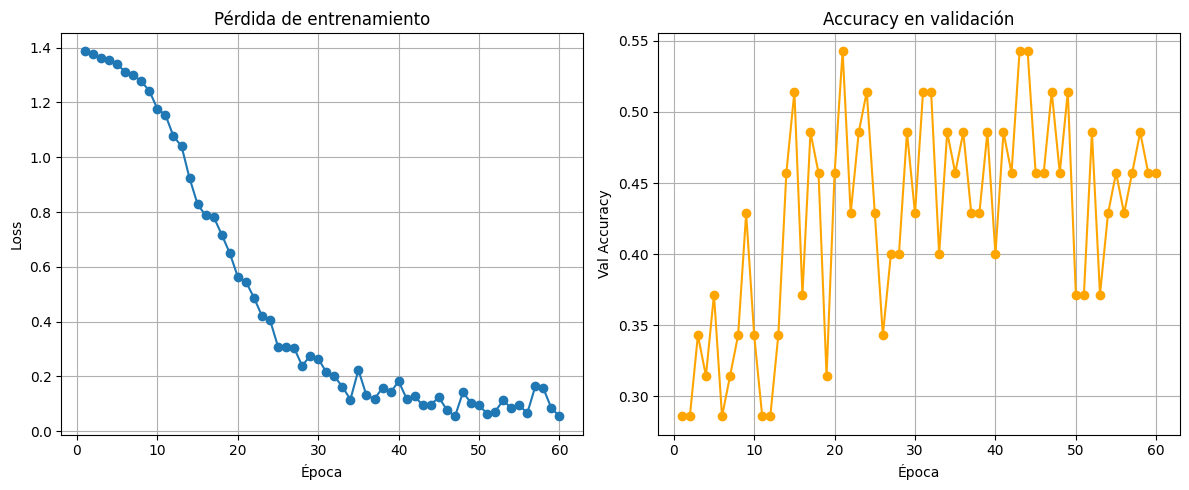

In [122]:
# ------------------------------------------------------------
# Configuración del modelo y entrenamiento
# ------------------------------------------------------------

# 1) Instancia la red neuronal con 4 salidas (estados de ánimo)
model = CatMoodNET(n_classes=4)

# 2) Define si usar GPU (cuda) o CPU
cuda = True
if cuda and torch.cuda.is_available():
    # Mueve el modelo a GPU si está disponible
    model = model.to('cuda')
    print("Se usará GPU para el entrenamiento.")
else:
    # En caso contrario, entrena en CPU
    print("Entrenamiento en CPU.")

# 3) Define la función de pérdida y el optimizador
#    - CrossEntropyLoss es adecuada para clasificación multiclase
criterio    = nn.CrossEntropyLoss()
#    - Adam es un optimizador adaptativo con LR inicial 1e-4
optimizador = optim.Adam(model.parameters(), lr=1e-4)

# 4) Llama al método de entrenamiento definido en la clase
#    - epochs: número de pasadas completas sobre el dataset
#    - data_loader: DataLoader de entrenamiento
#    - val_loader:  DataLoader de validación para medir generalización
#    - criterion & optimizer: configuraciones previas
#    - cuda: flag para usar GPU/CPU internamente
model.train_model(
    epochs=60,              # entrenar durante 40 épocas
    data_loader=train_loader,
    val_loader=val_loader,
    criterion=criterio,
    optimizer=optimizador,
    cuda=cuda
)


In [123]:
# ----------------------------------------------------------------
# 1) Funciones para contar aciertos y calcular precisión global
# ----------------------------------------------------------------

def contarCorrectas(net, batch, labels, func=None):
    """
    Cuenta cuántas predicciones son correctas en un lote.
    
    Parámetros
    ----------
    net   : nn.Module
        Modelo entrenado que devuelve logits de tamaño [batch, n_classes].
    batch : torch.Tensor
        Lote de imágenes, de forma [batch, 3, H, W].
    labels: torch.Tensor
        Etiquetas verdaderas de las imágenes, de forma [batch].
    func  : callable, opcional
        Función de preprocesamiento adicional que se aplique al batch
        antes de pasarlo por la red.

    Retorna
    -------
    torch.Tensor
        Número de predicciones correctas en el lote (escala).
    """
    if func is not None:
        batch = func(batch)
    # Forward pass: obtenemos logits de tamaño [batch, n_classes]
    salidas = net(batch)
    # Seleccionamos la clase con mayor logit para cada muestra
    preds = salidas.argmax(dim=1)
    # Comparamos con las etiquetas y contamos coincidencias
    return (preds == labels).sum()


def calcularPrecisionGlobal(net, data_loader, func=None, cuda=False):

    # Determina el dispositivo a partir de los parámetros del modelo
    device = next(net.parameters()).device
    # Asegura que el modelo está en modo evaluación
    net.eval()

    correctas = 0
    total     = 0
    # Desactiva el cálculo de gradientes
    with torch.no_grad():
        # Recorre todos los batches
        for images, labels in data_loader:
            # Si corresponde, mueve datos a GPU
            if cuda and torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            # Cuenta aciertos y suma al total
            correctas += contarCorrectas(net, images, labels, func).item()
            # Acumula el número real de muestras procesadas
            total     += labels.size(0)

    # Devuelve la precisión como porcentaje
    return 100 * correctas / total


# ----------------------------------------------------------------
# 2) Cálculo y visualización de precisión en train y val
# ----------------------------------------------------------------

# Calcula precisión en el conjunto de entrenamiento
prec_train = calcularPrecisionGlobal(model, train_loader, cuda=cuda)
# Calcula precisión en el conjunto de validación
prec_val   = calcularPrecisionGlobal(model, val_loader,   cuda=cuda)

# Muestra resultados formateados
print(f"Precisión en entrenamiento: {prec_train:.2f}%")
print(f"Precisión en validación:   {prec_val:.2f}%")

# ----------------------------------------------------------------
# 3) Guardado de los pesos entrenados
# ----------------------------------------------------------------

# Guarda los parámetros del modelo en un archivo .pth
torch.save(model.state_dict(), "CatMoodNET_model.pth")


Precisión en entrenamiento: 99.09%
Precisión en validación:   45.71%


Modelo cargado en CPU.


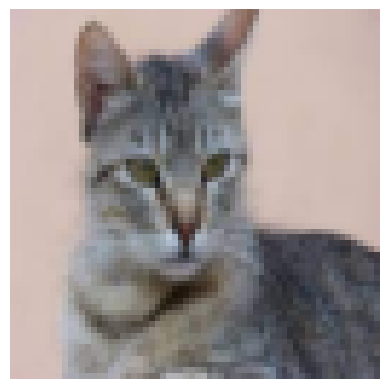

Etiqueta real:      neutral
Predicción de la red: alerta


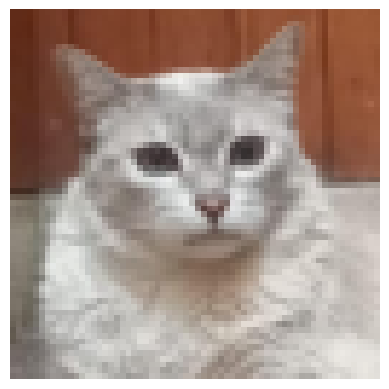

Etiqueta real:      neutral
Predicción de la red: neutral


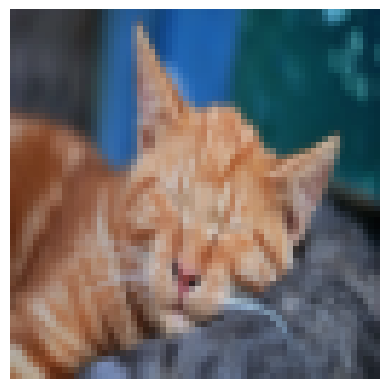

Etiqueta real:      dormido
Predicción de la red: dormido


In [124]:
# ----------------------------------------------------------------
# Definición de las 4 clases de emoción
# ----------------------------------------------------------------
# La tupla 'classes' debe coincidir con los índices (0–3) usados
# en entrenamiento y evaluación del modelo.
classes = ('alerta', 'dormido', 'enojado', 'neutral')

def mostrarImagen(imagen):
    """
    Desnormaliza y plotea una imagen tensorial.
    
    Parámetros
    ----------
    imagen : torch.Tensor
        Tensor de forma [3, H, W] con valores normalizados
        según ImageNet (mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]).
    
    Pasos
    -----
    1. Mosver el tensor a CPU.
    2. Desnormalizar: imagen*std + mean.
    3. Convertir a NumPy y reordñenar ejes para plt.imshow.
    4. Mostrar sin ejes.
    """
    imagen = imagen.cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = imagen * std + mean          # Desnormaliza
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

def predecirImagenAleatoria(modelo, dataset):
    """
    Elige una imagen aleatoria del dataset, la muestra y
    muestra su etiqueta real y la predicha por el modeslo.
    
    Parámetros
    ----------
    modelo : nn.Module
        Modelo ya entrenado en modo evaluación.
    dataset : Dataset
        Dataset indexable que retorna (imagen_tensor, etiqueta_int).
    """
    idx = random.randint(0, len(dataset) - 1)
    imagen, etiqueta_real = dataset[idx]

    mostrarImagen(imagen)

    modelo.eval()
    with torch.no_grad():
        logits = modelo(imagen.unsqueeze(0))   # Añade dimensión batch
        pred   = logits.argmax(1).item()       # Índice de la clase predicha

    print(f"Etiqueta real:      {classes[etiqueta_real]}")
    print(f"Predicción de la red: {classes[pred]}")

# ----------------------------------------------------------------
# Carga del modelo entrenado en CPU
# ----------------------------------------------------------------
model = CatMoodNET(n_classes=4)
model.load_state_dict(torch.load("CatMoodNET_model.pth",
                                 map_location=torch.device('cpu')))
model = model.to('cpu')
print("Modelo cargado en CPU.")

# ----------------------------------------------------------------
# Evaluación con el dataset de validación
# ----------------------------------------------------------------
# 
dataset_prueba = val_dataset    

# Mostrar predicciones de 3 imágenes aleatorias
for _ in range(3):
    predecirImagenAleatoria(model, dataset_prueba)


In [125]:
# ----------------------------------------------------------------
# device: usa GPU si está disponible, sino CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Lista de nombres de clases en el orden de sus índices 0–3
classes = ['alerta', 'dormido', 'enojado', 'neutral']

# ----------------------------------------------------------------
# Función: precision por clase y orden de menor a mayor
# ----------------------------------------------------------------
def clases_menor_precision(model, data_loader, classes, device):
    """
    Calcula la precisión (precision) para cada clase y devuelve
    una lista ordenada de tuplas (clase, precision) de menor a mayor.
    """
    model.eval()
    all_preds, all_trues = [], []

    with torch.no_grad():
        # Recorre todos los batches del loader
        for imgs, labels in data_loader:
            imgs = imgs.to(device)                # mover a GPU/CPU
            logits = model(imgs)                  # inferencia → logits
            preds = logits.argmax(dim=1).cpu().numpy()  # predicción de clase
            all_preds.extend(preds)               # acumula predicciones
            all_trues.extend(labels.numpy())      # acumula etiquetas reales

    # Convertir listas a arrays
    all_preds = np.array(all_preds)
    all_trues = np.array(all_trues)

    # Calcula precision por clase (sin promediar) y evita división por cero c:
    precs = precision_score(
        all_trues,
        all_preds,
        labels=list(range(len(classes))),
        average=None,
        zero_division=0
    )

    # Emparejar cada precisión con su nombre de clase
    paired = list(zip(classes, precs))
    # Ordenar de menor a mayor precisión
    return sorted(paired, key=lambda x: x[1])


model = CatMoodNET(n_classes=4)
model.load_state_dict(torch.load("CatMoodNET_model.pth", map_location=device))
model = model.to(device)

resultados = clases_menor_precision(model, val_loader, classes, device)
print("Clases ordenadas de menor a mayor precisión:")
for clase, prec in resultados:
    print(f"  {clase:<8s}: {prec*100:5.2f}%")


Clases ordenadas de menor a mayor precisión:
  dormido : 25.00%
  enojado : 42.86%
  alerta  : 46.67%
  neutral : 100.00%


In [126]:
# dResize a 64×64, convertir a tensor y normalizar con estadísticas de ImageNet
val_transforms = T.Compose([
    T.Resize((64, 64)),                            # redimensiona imágenes
    T.ToTensor(),                                  # de PIL a tensor [0,1]
    T.Normalize([0.485, 0.456, 0.406],             # media de ImageNet
                [0.229, 0.224, 0.225])             # desviación estándar de ImageNet
])

# ----------------------------------------------------------------
# 2) Carga del modelo en el dispositivo adecuado  cpu o gpu (a mi no me agarraba gpu :c)
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatMoodNET(n_classes=4)                    # instancia con 4 clases
model.load_state_dict(torch.load("CatMoodNET_model.pth", map_location=device))
model = model.to(device)                  
model.eval()                                       


classes = ('alerta', 'dormido', 'enojado', 'neutral')


def create_image_uploader(model, transform, classes, device):
    """
    Crea un widget para cargar una imagen, mostrarla y predecir su emoción.
    
    """
    # Widget para subir un archivo de imagen
    uploader = widgets.FileUpload(
        accept='image/*',    # solo imágenes
        multiple=False,      # un solo archivo a la vez
        description='Arrastra o selecciona imagen'
    )
    output = widgets.Output()  # zona para mostrar imagen y texto

    def on_upload_change(change):
        output.clear_output()   # limpia salidas anteriores
        if uploader.value:      # si hay un archivo cargado
            file_info = uploader.value[0]               # primer archivoñ
            img_data = file_info['content']             # bytes de la imagen
            img = Image.open(io.BytesIO(img_data))     # abrir con PIL
            img = img.convert("RGB")                   # asegurar 3 canales

            with output:
                display(img)  # muestra la imagen original

                # Preprocesar y preparar batch
                img_tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    logits = model(img_tensor)             
                    pred_idx = logits.argmax(dim=1).item() # índice de clase

                # Mostrar nombre de la clase predicha
                print(f"Predicción: {classes[pred_idx]}")

    # Conecta el callback y muestra los widgets
    uploader.observe(on_upload_change, names='value')
    display(widgets.VBox([uploader, output]))

create_image_uploader(model, val_transforms, classes, device)
